In [ ]:
! git clone https://github.com/MrPio/KAN_tests
! mv KAN_tests/* ./
! rm -r KAN_tests/

In [6]:
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from tqdm import tqdm

from efficient_kan.kan import KAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

None


# KAN
In this notebook we demonstrate how the catastrophic forgetting lightly affect KANs.
We train an KAN on a sorted MNIST.

In [110]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset)//1), key=lambda idx: train_dataset.targets[idx])
# sorted_indices = range(len(train_dataset)//10)
train_dataset = torch.utils.data.Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
# Test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [108]:
import time
# Training the model
def train(model, checkpoint, epochs=5):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    line, = ax.plot([], [], 'bo-',label='accuracy')
    line2, = ax2.plot([], [], 'r-', label='lr')
    x_data, acc_data, lr_data = [], [],[]
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    for epoch in range(epochs):
        model.train()
        with tqdm(train_loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                # Updating the plot
                x_data.append(i)
                acc_data.append(accuracy.item())
                lr_data.append(optimizer.param_groups[0]['lr'])
                line.set_data(x_data, acc_data)
                line2.set_data(x_data, lr_data)
                ax.relim()
                ax.autoscale_view()                
                ax2.relim()
                ax2.autoscale_view()                
                fig.canvas.draw()
                fig.canvas.flush_events()
        # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        torch.save(model.state_dict(), checkpoint)



In [ ]:
def validate(model):
    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28 * 28).to(device)
            output = model(images)
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")

100%|██████████| 94/94 [00:07<00:00, 12.08it/s, accuracy=0.292, loss=2.3, lr=0.1]  


Epoch 1, Loss: 2.3025853633880615


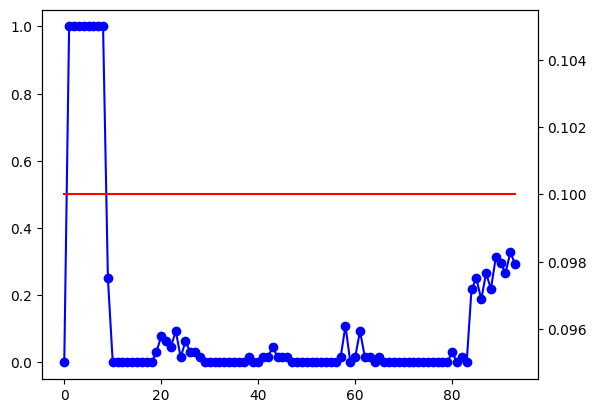

In [109]:
model = KAN([28 * 28, 64, 10]).to(device)
train(model, 'checkpoint/kan_mnist.pth')